In [22]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Définir les paramètres

In [23]:
IMAGE_SIZE = (128, 128)
#SEQUENCE_LENGTH = 5  # nombre d'images par séquence
SEQUENCE_LENGTH = 1
DATASET_PATH = "dataset"



Charger les images et créer les séquences

In [24]:
#plus images
# def load_sequences_from_folder(folder_path, label):
#     files = sorted(os.listdir(folder_path))
#     sequences = []
#     labels = []

#     for i in range(len(files) - SEQUENCE_LENGTH + 1):
#         sequence = []
#         for j in range(SEQUENCE_LENGTH):
#             img_path = os.path.join(folder_path, files[i + j])
#             image = load_img(img_path, target_size=IMAGE_SIZE)
#             image = img_to_array(image) / 255.0  # Normalisation
#             sequence.append(image)
#         sequences.append(sequence)
#         labels.append(label)
    
#     return np.array(sequences), np.array(labels)

#une seule image 
def load_sequences_from_folder(folder_path, label):
    files = sorted(os.listdir(folder_path))
    sequences = []
    labels = []

    for i in range(len(files) - SEQUENCE_LENGTH + 1):
        img_path = os.path.join(folder_path, files[i])
        image = load_img(img_path, target_size=IMAGE_SIZE)
        image = img_to_array(image) / 255.0  # Normalisation
        sequences.append(image)  # juste l'image seule
        labels.append(label)
    
    return np.array(sequences), np.array(labels)



Charger les deux classes

In [25]:
# Uptrend = 1, Downtrend = 0
X_up, y_up = load_sequences_from_folder(os.path.join(DATASET_PATH, "uptrend"), label=1)
X_down, y_down = load_sequences_from_folder(os.path.join(DATASET_PATH, "downtrend"), label=0)

# Fusionner les données
X = np.concatenate((X_up, X_down), axis=0)
y = np.concatenate((y_up, y_down), axis=0)


Shuffle et split en Train / Val / Test

In [26]:
# Mélanger les données
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# Séparer : 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
# class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: 1.0 * len(y_train) / 2 / 1177, 1: 1.0 * len(y_train) / 2 / 1419}


print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


{np.int64(0): np.int64(1177), np.int64(1): np.int64(1419)}
X_train: (2596, 128, 128, 3)
X_val: (556, 128, 128, 3)
X_test: (557, 128, 128, 3)


visualisation des donnes 

In [27]:
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

#plusoeur images
# for i in range(3):  # Les 3 premières séquences
#     print(f"Sequence {i} - Label: {y_train[i]}")
    
#     sequence = X_train[i]  # (par ex: (10, 128, 128, 3))
    
#     # Afficher chaque image de la séquence
#     fig, axs = plt.subplots(1, len(sequence), figsize=(15, 2))
#     for j, img in enumerate(sequence):
#         axs[j].imshow(img)
#         axs[j].axis('off')
#         axs[j].set_title(f"Img {j+1}")
#     plt.suptitle(f"Label: {y_train[i]}")
#     plt.show()



#une seule image 
# for i in range(3):
#     print(f"Image {i} - Label: {y_train[i]}")

#     # Convertir les valeurs de [0, 1] à [0, 255] pour un affichage correct
#     image = (X_train[i] * 255).astype('uint8')


    

#     # Afficher l’image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(image_resized)
#     plt.title(f"Label: {'Uptrend' if y_train[i]==1 else 'Downtrend'}")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

Chargement des données .npy

In [28]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

print("X_train:", X_train.shape)


X_train: (2596, 128, 128, 3)


 Création du modèle CNN + LSTM

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout, BatchNormalization

def create_model(input_shape):
    model = Sequential()
    
    # Partie CNN pour extraire les features de chaque image
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))
    
    model.add(TimeDistributed(Flatten()))
    
    # Partie LSTM pour traiter la séquence temporelle
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    
    # Couche de sortie
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

Entraînement du modèle

In [30]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


# Entraînement
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=30,
#     batch_size=32,
#     callbacks=[early_stop, reduce_lr],
#     class_weight=class_weights_dict
# )


datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
)

datagen.fit(X_train)
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks,
                    class_weight=class_weights_dict)



NameError: name 'model' is not defined

Affichage des courbes d'entraînement

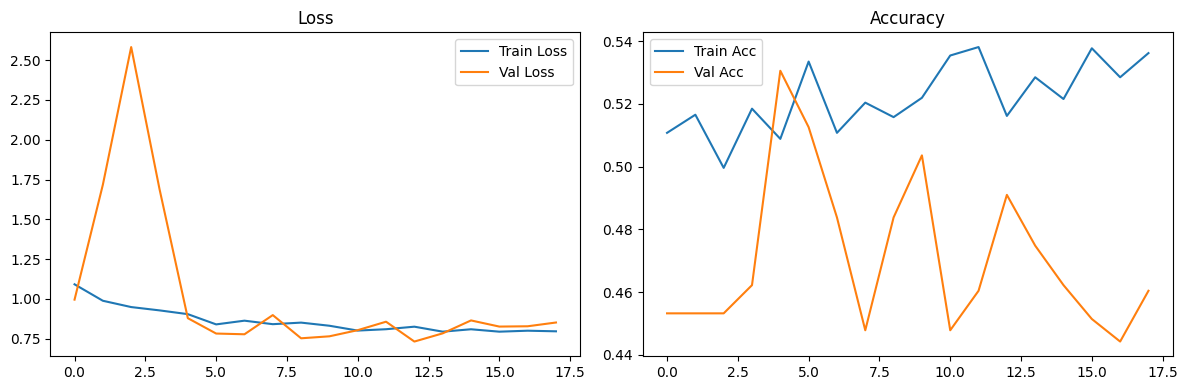

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Rapport de classification
print(classification_report(y_test, y_pred_classes))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

Évaluation sur le test set

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.4899 - loss: 0.7483
Test Accuracy: 0.4901


Exemple de prédiction

In [ ]:
pred = model.predict(X_test[:5])
pred_labels = (pred > 0.5).astype(int)

for i in range(5):
    print(f"Vrai label : {y_test[i]}, Prédit : {pred_labels[i][0]}")

pred = (model.predict(X_test) > 0.5).astype(int)
for i in range(len(pred)):
    if pred[i] != y_test[i]:
        print(f"Erreur : Vrai = {y_test[i]}, Prédit = {pred[i][0]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Vrai label : 0, Prédit : 1
Vrai label : 1, Prédit : 1
Vrai label : 1, Prédit : 0
Vrai label : 0, Prédit : 0
Vrai label : 1, Prédit : 0
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
Erreur : Vrai = 0, Prédit = 1
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 0, Prédit = 1
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 0, Prédit = 1
Erreur : Vrai = 0, Prédit = 1
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 0, Prédit = 1
Erreur : Vrai = 1, Prédit = 0
Erreur : Vrai = 1, Prédit = 0
Erreur

Rapport et matrice de confusion

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.77      0.58       252
           1       0.58      0.26      0.36       305

    accuracy                           0.49       557
   macro avg       0.52      0.51      0.47       557
weighted avg       0.52      0.49      0.46       557



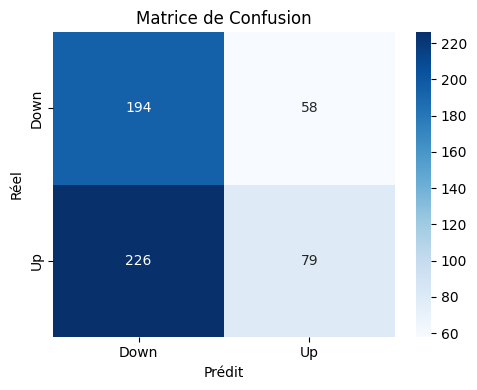

In [ ]:
# Rapport
pred = model.predict(X_test)
pred_labels = (pred > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, pred_labels))

# Matrice de confusion
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de Confusion")
plt.tight_layout()
plt.show()

